In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tifffile
from skimage import measure
import warnings

warnings.filterwarnings("ignore")

# Set up paths
BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "data"
RAW_DIR = DATA_DIR / "raw"
OUTPUT_PARAM_DIR = RAW_DIR / "output_parameter_sweep"
PYBAMM_DIR = RAW_DIR / "final_pybamm_output"

# Display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.width", None)
pd.set_option("display.float_format", "{:.6g}".format)

In [2]:
# Set the sample and parameter IDs to analyze
SAMPLE_ID = 5099
PARAM_ID = 0

In [3]:
# %%
# Load data sources
print("\n📂 Loading data sources...")

# Load final_results.csv
final_results = pd.read_csv(OUTPUT_PARAM_DIR / "final_results.csv")
sample_final = (
    final_results[final_results["id"] == SAMPLE_ID].iloc[0]
    if len(final_results[final_results["id"] == SAMPLE_ID]) > 0
    else None
)

if sample_final is not None:
    print(f"✓ Loaded final_results.csv for sample {SAMPLE_ID}")
else:
    print(f"⚠️  Sample {SAMPLE_ID} not found in final_results.csv")

# Load taufactor_results.csv
tau_results = pd.read_csv(OUTPUT_PARAM_DIR / "taufactor_results.csv")
sample_tau = (
    tau_results[tau_results["id"] == SAMPLE_ID].iloc[0]
    if len(tau_results[tau_results["id"] == SAMPLE_ID]) > 0
    else None
)

if sample_tau is not None:
    print(f"✓ Loaded taufactor_results.csv for sample {SAMPLE_ID}")
else:
    print(f"⚠️  Sample {SAMPLE_ID} not found in taufactor_results.csv")

# Load parquet data - UPDATED: files are now named sample_XXXXX.parquet
parquet_file = PYBAMM_DIR / f"sample_{SAMPLE_ID}.parquet"
if parquet_file.exists():
    parquet_df = pd.read_parquet(parquet_file)
    # Filter for the specific param_id
    if "param_id" in parquet_df.columns:
        sample_parquet = (
            parquet_df[parquet_df["param_id"] == PARAM_ID].iloc[0]
            if len(parquet_df[parquet_df["param_id"] == PARAM_ID]) > 0
            else None
        )
        if sample_parquet is not None:
            print(
                f"✓ Loaded parquet data: param_id = {sample_parquet.get('param_id', 'N/A')}"
            )
        else:
            print(f"⚠️  Param {PARAM_ID} not found in parquet")
    else:
        sample_parquet = parquet_df.iloc[0]
        print(f"✓ Loaded parquet data (no param_id column)")
else:
    sample_parquet = None
    print(f"⚠️  No parquet file found at {parquet_file}")

# Load TIFF image - UPDATED: now sample_XXXXX.tif format
image_file = OUTPUT_PARAM_DIR / f"sample_{SAMPLE_ID}.tif"
if image_file.exists():
    sem_image = tifffile.imread(image_file)
    print(f"✓ Loaded TIFF image: {image_file.name}")
    print(f"  Shape: {sem_image.shape}")
    print(f"  Dtype: {sem_image.dtype}")
    print(f"  Value range: [{sem_image.min()}, {sem_image.max()}]")
else:
    sem_image = None
    print(f"⚠️  No TIFF image found at {image_file}")

print("\n" + "=" * 80)


📂 Loading data sources...
✓ Loaded final_results.csv for sample 5099
✓ Loaded taufactor_results.csv for sample 5099
✓ Loaded parquet data: param_id = 0
✓ Loaded TIFF image: sample_5099.tif
  Shape: (128, 128, 128)
  Dtype: uint8
  Value range: [0, 255]



In [4]:
def truncate_array(arr, max_len=5):
    """Truncate long arrays for display"""
    if isinstance(arr, (list, np.ndarray)):
        arr = np.array(arr) if isinstance(arr, list) else arr
        if len(arr) > max_len:
            return (
                f"[{arr[0]:.3g}, {arr[1]:.3g}, ..., {arr[-1]:.3g}] (length: {len(arr)})"
            )
        else:
            return str([f"{x:.3g}" for x in arr])
    return arr


# Combine all data sources
data_dict = {}

# Add tau factor data
if sample_tau is not None:
    data_dict["D_eff (tau)"] = sample_tau.get("D_eff", np.nan)
    data_dict["porosity_measured (tau)"] = sample_tau.get("porosity_measured", np.nan)
    data_dict["tau_factor (tau)"] = sample_tau.get("tau_factor", np.nan)
    data_dict["error (tau)"] = sample_tau.get("error", np.nan)

# Add final results data
if sample_final is not None:
    for col in sample_final.index:
        if col not in ["id"]:  # Skip id as we're using it as identifier
            data_dict[col] = sample_final[col]

# Add parquet data with 'input_' prefix
if sample_parquet is not None:
    for col in sample_parquet.index:
        if col.startswith("input_") or col in [
            "bruggeman_derived",
            "nominal_capacity_Ah",
        ]:
            value = sample_parquet[col]
            # Truncate arrays
            if isinstance(value, (list, np.ndarray)):
                value = truncate_array(value)
            data_dict[col] = value

# Create DataFrame
df_display = pd.DataFrame(list(data_dict.items()), columns=["Parameter", "Value"])
df_display.index.name = "Index"

print(f"\n{'='*80}")
print(f"COMPREHENSIVE DATA FOR SAMPLE {SAMPLE_ID} | PARAM {PARAM_ID}")
print(f"{'='*80}\n")
print(df_display.to_string())
print(f"\n{'='*80}")


COMPREHENSIVE DATA FOR SAMPLE 5099 | PARAM 0

                                                           Parameter            Value
Index                                                                                
0                                                        D_eff (tau)         0.211224
1                                            porosity_measured (tau)         0.542028
2                                                   tau_factor (tau)          2.56613
3                                                        error (tau)              NaN
4                                                             status          success
5                                                           filename  sample_5099.tif
6                                                         duration_s             0.19
7                                                             gpu_id                3
8                                                          error_msg              NaN
9      

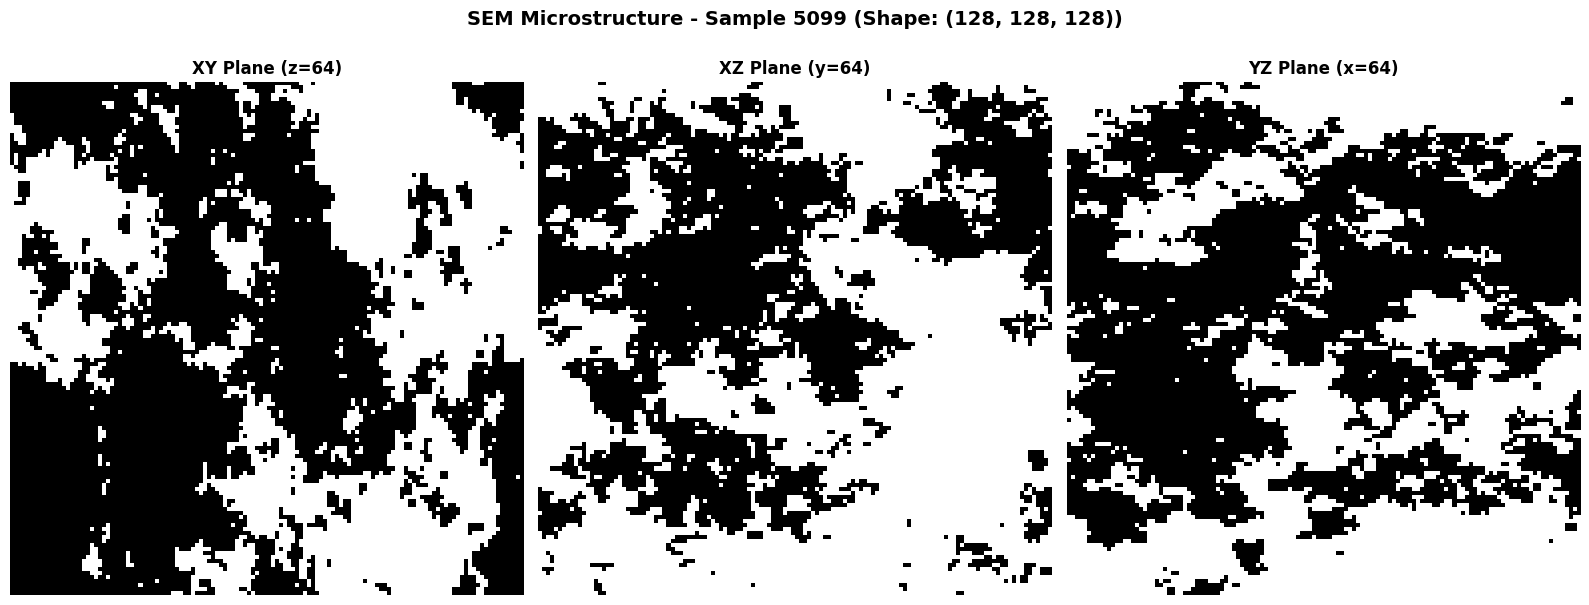

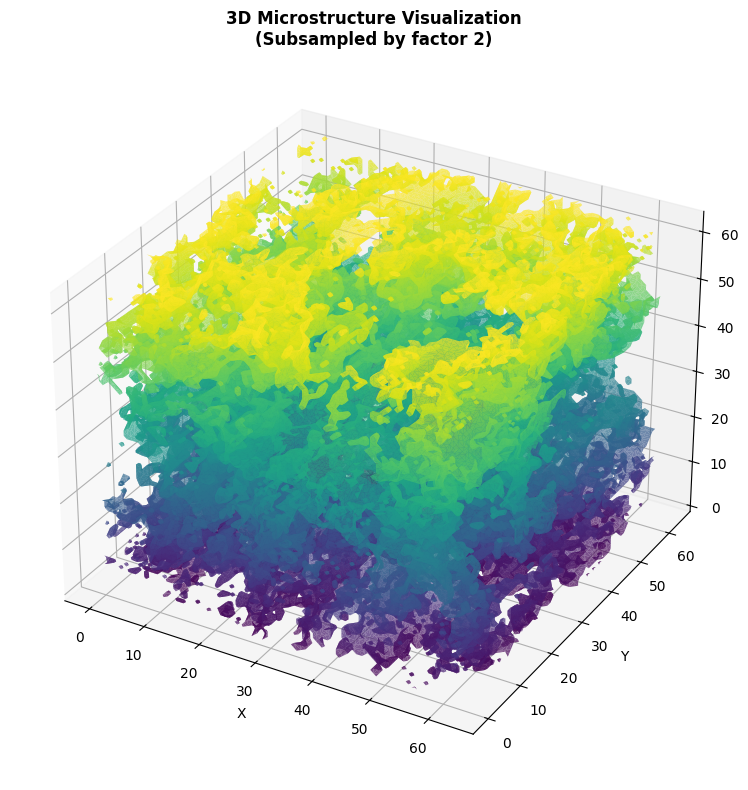

In [5]:
if sem_image is not None:
    fig = plt.figure(figsize=(16, 6))

    # 2D Slice Views
    mid_z = sem_image.shape[0] // 2
    mid_y = sem_image.shape[1] // 2
    mid_x = sem_image.shape[2] // 2

    # XY plane (top view)
    ax1 = fig.add_subplot(131)
    ax1.imshow(sem_image[mid_z, :, :], cmap="gray")
    ax1.set_title(f"XY Plane (z={mid_z})", fontsize=12, fontweight="bold")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.axis("off")

    # XZ plane (side view)
    ax2 = fig.add_subplot(132)
    ax2.imshow(sem_image[:, mid_y, :], cmap="gray")
    ax2.set_title(f"XZ Plane (y={mid_y})", fontsize=12, fontweight="bold")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Z")
    ax2.axis("off")

    # YZ plane (front view)
    ax3 = fig.add_subplot(133)
    ax3.imshow(sem_image[:, :, mid_x], cmap="gray")
    ax3.set_title(f"YZ Plane (x={mid_x})", fontsize=12, fontweight="bold")
    ax3.set_xlabel("Y")
    ax3.set_ylabel("Z")
    ax3.axis("off")

    plt.suptitle(
        f"SEM Microstructure - Sample {SAMPLE_ID} (Shape: {sem_image.shape})",
        fontsize=14,
        fontweight="bold",
        y=1.02,
    )
    plt.tight_layout()
    plt.show()

    # 3D Visualization (subsampled for performance)
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Subsample for visualization (every nth voxel)
    subsample_factor = max(1, sem_image.shape[0] // 50)
    subsampled = sem_image[::subsample_factor, ::subsample_factor, ::subsample_factor]

    # Create isosurface
    try:
        threshold = subsampled.mean()
        verts, faces, _, _ = measure.marching_cubes(subsampled, threshold)

        ax.plot_trisurf(
            verts[:, 0],
            verts[:, 1],
            faces,
            verts[:, 2],
            cmap="viridis",
            alpha=0.7,
            linewidth=0,
            antialiased=True,
        )
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_title(
            f"3D Microstructure Visualization\n(Subsampled by factor {subsample_factor})",
            fontsize=12,
            fontweight="bold",
        )
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not generate 3D visualization: {e}")
        print("Showing 3D scatter plot instead...")

        # Alternative: scatter plot
        threshold = subsampled.mean()
        z, y, x = np.where(subsampled > threshold)
        ax.scatter(x, y, z, c=subsampled[z, y, x], cmap="viridis", alpha=0.5, s=1)
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_title(
            f"3D Microstructure (Scatter Plot)\n(Subsampled by factor {subsample_factor})",
            fontsize=12,
            fontweight="bold",
        )
        plt.tight_layout()
        plt.show()
else:
    print("No SEM image available for visualization")


ELECTROCHEMICAL CYCLE DATA


CYCLE FIRST:
----------------------------------------
Time points: 1357
Time range: 0.0000 - 3.3509 hours
Voltage range: 3.0000 - 4.2000 V
Current range: -5.0000 - 5.0000 A

CYCLE MIDDLE:
----------------------------------------
Time points: 1270
Time range: 45.0772 - 48.2050 hours
Voltage range: 3.0000 - 4.2000 V
Current range: -5.0000 - 5.0000 A

CYCLE LAST:
----------------------------------------
Time points: 1167
Time range: 88.1369 - 91.1576 hours
Voltage range: 3.0000 - 4.2000 V
Current range: -5.0000 - 5.0000 A

CAPACITY FADE:
----------------------------------------
Total cycles: 29
Initial capacity: 4.6635 Ah
Final capacity: 3.5051 Ah
Capacity retention: 75.16%
EOL cycle (measured): 13.0
Nominal capacity: 5.0 Ah


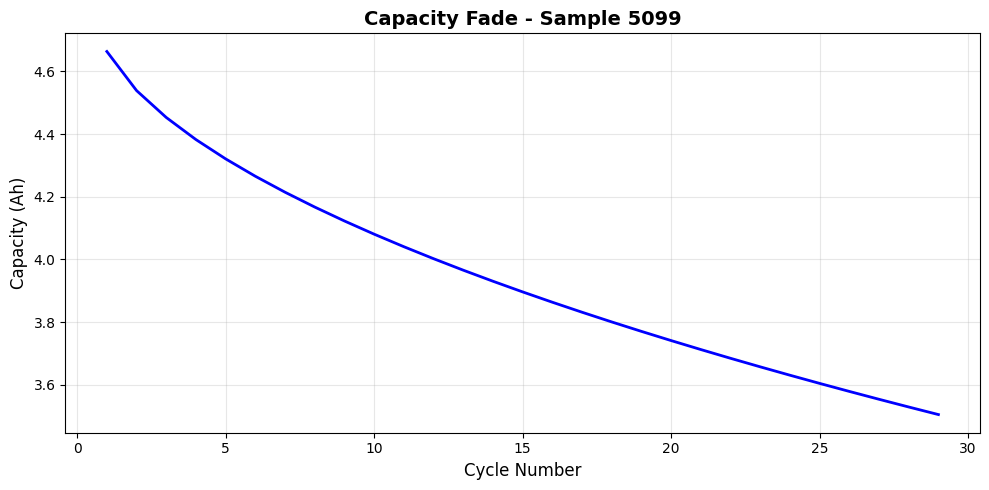

In [6]:
if sample_parquet is not None:
    print(f"\n{'='*80}")
    print(f"ELECTROCHEMICAL CYCLE DATA")
    print(f"{'='*80}\n")

    # Extract cycle data - note the field names are: Current_A, Time_h, Voltage_V
    cycle_keys = ["cycle_first", "cycle_middle", "cycle_last"]

    for cycle_key in cycle_keys:
        if cycle_key in sample_parquet.index:
            cycle_data = sample_parquet[cycle_key]
            if isinstance(cycle_data, dict):
                print(f"\n{cycle_key.upper().replace('_', ' ')}:")
                print("-" * 40)

                # Extract time series data with correct field names
                if "Time_h" in cycle_data and "Voltage_V" in cycle_data:
                    time = np.array(cycle_data["Time_h"])
                    voltage = np.array(cycle_data["Voltage_V"])
                    current = np.array(cycle_data.get("Current_A", []))

                    print(f"Time points: {len(time)}")
                    print(f"Time range: {time[0]:.4f} - {time[-1]:.4f} hours")
                    print(f"Voltage range: {voltage.min():.4f} - {voltage.max():.4f} V")
                    if len(current) > 0:
                        print(
                            f"Current range: {current.min():.4f} - {current.max():.4f} A"
                        )
                else:
                    print("Cycle data structure:", list(cycle_data.keys())[:10])

    # Capacity trend - note: capacity_trend_ah (lowercase)
    if (
        "capacity_trend_cycles" in sample_parquet.index
        and "capacity_trend_ah" in sample_parquet.index
    ):
        cycles = np.array(sample_parquet["capacity_trend_cycles"])
        capacity = np.array(sample_parquet["capacity_trend_ah"])

        print(f"\nCAPACITY FADE:")
        print("-" * 40)
        print(f"Total cycles: {len(cycles)}")
        print(f"Initial capacity: {capacity[0]:.4f} Ah")
        print(f"Final capacity: {capacity[-1]:.4f} Ah")
        print(f"Capacity retention: {(capacity[-1]/capacity[0]*100):.2f}%")
        print(
            f"EOL cycle (measured): {sample_parquet.get('eol_cycle_measured', 'N/A')}"
        )
        print(
            f"Nominal capacity: {sample_parquet.get('nominal_capacity_Ah', 'N/A')} Ah"
        )

        # Plot capacity fade
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(cycles, capacity, "b-", linewidth=2)
        ax.set_xlabel("Cycle Number", fontsize=12)
        ax.set_ylabel("Capacity (Ah)", fontsize=12)
        ax.set_title(
            f"Capacity Fade - Sample {SAMPLE_ID}", fontsize=14, fontweight="bold"
        )
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("No cycle data available")

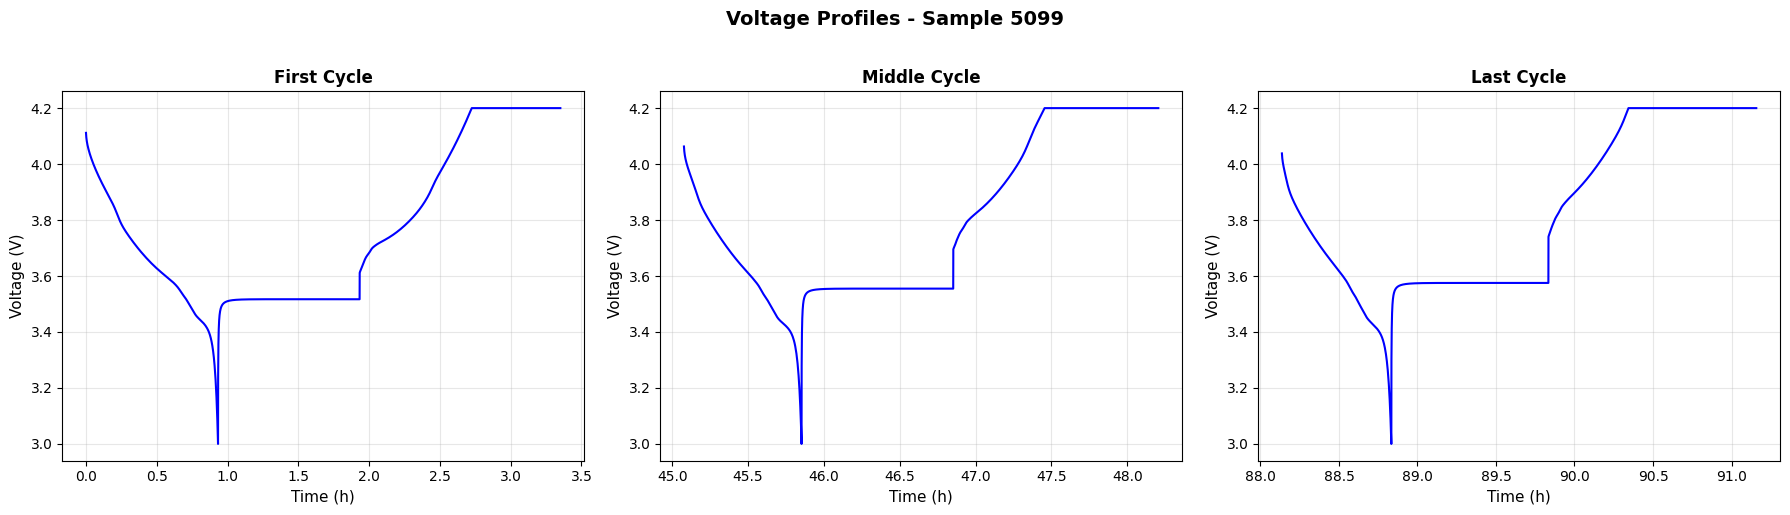

In [7]:
if sample_parquet is not None:
    # Check if we have cycle data
    has_cycles = any(
        key in sample_parquet.index
        for key in ["cycle_first", "cycle_middle", "cycle_last"]
    )

    if has_cycles:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        cycle_names = ["cycle_first", "cycle_middle", "cycle_last"]
        titles = ["First Cycle", "Middle Cycle", "Last Cycle"]

        for idx, (cycle_key, title) in enumerate(zip(cycle_names, titles)):
            if cycle_key in sample_parquet.index:
                cycle_data = sample_parquet[cycle_key]
                if (
                    isinstance(cycle_data, dict)
                    and "Time_h" in cycle_data
                    and "Voltage_V" in cycle_data
                ):
                    time = np.array(cycle_data["Time_h"])
                    voltage = np.array(cycle_data["Voltage_V"])

                    axes[idx].plot(time, voltage, "b-", linewidth=1.5)
                    axes[idx].set_xlabel("Time (h)", fontsize=11)
                    axes[idx].set_ylabel("Voltage (V)", fontsize=11)
                    axes[idx].set_title(title, fontsize=12, fontweight="bold")
                    axes[idx].grid(True, alpha=0.3)
                else:
                    axes[idx].text(
                        0.5,
                        0.5,
                        "No data",
                        ha="center",
                        va="center",
                        transform=axes[idx].transAxes,
                        fontsize=14,
                    )
                    axes[idx].set_title(title, fontsize=12, fontweight="bold")
            else:
                axes[idx].text(
                    0.5,
                    0.5,
                    "No data",
                    ha="center",
                    va="center",
                    transform=axes[idx].transAxes,
                    fontsize=14,
                )
                axes[idx].set_title(title, fontsize=12, fontweight="bold")

        plt.suptitle(
            f"Voltage Profiles - Sample {SAMPLE_ID}",
            fontsize=14,
            fontweight="bold",
            y=1.02,
        )
        plt.tight_layout()
        plt.show()
    else:
        print("No cycle data available for plotting")
else:
    print("No parquet data available")